In [1]:
'''
Usage:
1. Data directory must be in the same directory as the script
2. Images, lables and superpixels directories must be inside data directory
3. Script parameters must be specified in script parameters cell
'''

'\nUsage:\n1. Data directory must be in the same directory as the script\n2. Images, lables and superpixels directories must be inside data directory\n3. Script parameters must be specified in script parameters cell\n'

In [9]:
import numpy as np
import os
import collections
import matplotlib.pyplot as plt
import skimage.future.graph as skigraph
import shutil
import pickle
import keras
import tensorflow as tf
import networkx as nx
import time
import sys

from kgcnn.literature.GCN import make_model
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from kgcnn.utils.learning import LinearLearningRateScheduler
from PIL import Image, ImageOps
from radiomics import featureextractor
import numpy.ma as ma
import nrrd
import warnings

In [10]:
# config

# script parameterss
MAIN_DIR_PATH = "/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint"
DATA_DIR_NAME = "input/data_set_2"
IMAGES_DIR_NAME = "images"
SUPERPIXELS_LABELS_DIR_NAME = "labels"
SUPERPIXELS_DIR_NAME = "superpixels"
MASKS_DIR_NAME = "masks"

IMAGE_FILE_PREFIX = "STIR"
SUPERPIXELS_FILE_PREFIX = "1000SuperPixelMeanValueTPS_"

IMG_CMAP = "pink"
EDGE_CMAP = "viridis"
EDGE_WIDTH = 2

CREATE_SUPERPIXELS_IMAGES = False

# globals
DATA_DIR_PATH = f"{MAIN_DIR_PATH}/{DATA_DIR_NAME}"
IMAGES_DIR_PATH = f"{DATA_DIR_PATH}/{IMAGES_DIR_NAME}"
SUPERPIXELS_LABELS_DIR_PATH = f"{DATA_DIR_PATH}/{SUPERPIXELS_LABELS_DIR_NAME}"
SUPERPIXELS_DIR_PATH = f"{DATA_DIR_PATH}/{SUPERPIXELS_DIR_NAME}"
MASKS_DIR_PATH = f"{DATA_DIR_PATH}/{MASKS_DIR_NAME}"
subgraphs_info = []

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)

In [11]:
# utils
def show_2d_image_from_3d_image(image_3d, index_of_2d_image):
    plt.figure(figsize = (20,20))
    plt.imshow(image_3d[:,:,index_of_2d_image], cmap='gray')
    plt.show()
    
def save_object(filename, obj):
    obj_file = open(filename, 'wb')
    pickle.dump(obj, obj_file)
    obj_file.close()
    
def load_object(filename):
    obj_file = open(filename, 'rb')
    obj = pickle.load(obj_file)
    obj_file.close()
    
    return obj

# read data
def read_binary_data_3D(file_name, image_size, image_count, voxel_bytes, signed='Y', byte_order='BE'):
    if voxel_bytes == 2:
        if signed == 'N':
            d = np.zeros((image_size, image_size, image_count), np.uint16)
        else:
            d = np.zeros((image_size, image_size, image_count), np.int16)
    elif voxel_bytes == 1:
        if signed == 'N':
            d = np.zeros((image_size, image_size, image_count), np.uint8)
        else:
            d = np.zeros((image_size, image_size, image_count), np.int8)
    else:
        print('Wrong number of bytes per voxel')
        return

    f = open(file_name, "rb")
    for i in range(0, image_count):
        for j in range(0, image_size):
            for k in range(0, image_size):
                byte = f.read(voxel_bytes)
                if voxel_bytes == 2:
                    if byte_order == 'BE':
                        a = 256 * byte[0] + byte[1]
                    else:
                        a = byte[0] + 256 * byte[1]
                else:
                    a = byte[0]
                d[j,k,i] = a
    f.close()
    return d

# rag creation
FileInfo = collections.namedtuple('FileInfo', ['name', 'patient_id', 'height', 'width', 'image_count', 'voxel_bytes'])


class Rag:
    def __init__(self, rag, superpixels_labels, file_id):
        self.rag = rag
        self.superpixels_labels = superpixels_labels
        self.file_id = file_id

class Subgraph:
    def __init__(self, rag, superpixel_label, neighbor_graph, label):
        self.rag = rag
        self.superpixel_label = superpixel_label
        self.neighbor_graph = neighbor_graph
        self.label = label
        self.unnormalized_edge_indices = None
        self.normalized_edge_indices = None
        self.edges = None
        self.nodes = None
        
def create_rag_on_superpixels_image(superpixel_labels, superpixels, rag, file_info, image_number, edge_width, img_cmap, edge_cmap):
    PATIENT_ID_DIR_PATH = f"saved_objects/rags/{file_info.patient_id}"
    RAG_IMAGE_PATH = f"{PATIENT_ID_DIR_PATH}/rag_{image_number}_{file_info.height}_{file_info.width}_{file_info.image_count}_{file_info.voxel_bytes}_.png"
    if os.path.exists(RAG_IMAGE_PATH):
        shutil.rmtree(PATIENT_ID_DIR_PATH)
    os.makedirs(PATIENT_ID_DIR_PATH, exist_ok=True)
    
    rag_file = open(RAG_IMAGE_PATH, "w")
    rag_file.close()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
    ax.axis('off')
    lc = skigraph.show_rag(
        superpixel_labels, rag, superpixels, img_cmap=img_cmap, edge_width=edge_width, edge_cmap=edge_cmap, ax=ax
    )
    fig.colorbar(lc, fraction=0.04, ax=ax)
    fig.savefig(RAG_IMAGE_PATH)
    plt.close(fig) 
    
def assign_label(mask, superpixels_labels, rag, image):
    white_pixels_count = {}
    total_pixels_count = {}
    for (i, row) in enumerate(superpixels_labels):
        for (j, label) in enumerate(row):
            if label in total_pixels_count:
                total_pixels_count[label] += 1
            else:
                total_pixels_count[label] = 1 
            if mask[i][j] == 1:
                if label in white_pixels_count:
                    white_pixels_count[label] += 1
                else:
                    white_pixels_count[label] = 1
                    
    for (i, node) in enumerate(rag):
        if i in white_pixels_count and white_pixels_count[i] / total_pixels_count[i] >= 0.6:
            rag.nodes[node]['label'] = '1'
        else:
            rag.nodes[node]['label'] = '0'
            
            
    # assign radiomics features
    labels = np.unique(superpixels_labels)
    for label in labels:
        mask = (superpixels_labels == label).astype(int)
        #mx = ma.masked_array(image, mask=np.where((mask==0)|(mask==1), mask^1, mask))
        nrrd.write(f"{label}_image.nrrd", image)
        nrrd.write(f"{label}_label.nrrd", mask)
        imagePath = os.path.join(MAIN_DIR_PATH, str(label) + "_image.nrrd")
        labelPath = os.path.join(MAIN_DIR_PATH, str(label) + "_label.nrrd")
        extractor = featureextractor.RadiomicsFeatureExtractor()
        try:             
            result = extractor.execute(imagePath, labelPath)
        except:
            print(mask)
            print(label)
            print("FAILED")
            nrrd.write(f"FAILED_{label}_label.nrrd", mask)
                
        rag.nodes[label]['original_firstorder_Mean'] = result['original_firstorder_Mean']
        rag.nodes[label]['original_firstorder_Variance'] = result['original_firstorder_Variance']
        rag.nodes[label]['original_glcm_ClusterTendency'] = result['original_glcm_ClusterTendency']
        rag.nodes[label]['original_glcm_Correlation'] = result['original_glcm_Correlation']
        rag.nodes[label]['original_ngtdm_Contrast'] = result['original_ngtdm_Contrast']
        rag.nodes[label]['original_glrlm_RunEntropy'] = result['original_glrlm_RunEntropy']
        rag.nodes[label]['original_gldm_DependenceEntropy'] = result['original_gldm_DependenceEntropy']
        rag.nodes[label]['original_gldm_SmallDependenceEmphasis'] = result['original_gldm_SmallDependenceEmphasis']
        rag.nodes[label]['original_glrlm_GrayLevelNonUniformity'] = result['original_glrlm_GrayLevelNonUniformity']
        rag.nodes[label]['original_ngtdm_Busyness'] = result['original_ngtdm_Busyness']        
        rag.nodes[label]['original_glszm_ZoneEntropy'] = result['original_glszm_ZoneEntropy']
        rag.nodes[label]['original_glszm_SizeZoneNonUniformity'] = result['original_glszm_SizeZoneNonUniformity']
    
def process_bmp_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path, masks_dir_path):
    file_names = os.listdir(images_dir_path)
    rags = []
    
    for (image_index, file_name) in enumerate(file_names):
        print(f"Processing file: {image_index + 1}/{len(file_names)}")
        img = ImageOps.grayscale((Image.open(f"{IMAGES_DIR_PATH}/{file_name}")))
        img = np.array(img)
        img = img/(img.max()/255.0)  
        file_id = file_name.split("_")[-1][0:-4]
        mask = np.array(ImageOps.grayscale(Image.open(f"{masks_dir_path}/mask_{file_id}.bmp")))
        try:
            superpixels_labels = np.fromfile(f"{superpixels_labels_dir_path}/org_{file_id}.dat", dtype=np.dtype((np.int32, (img.shape[0], img.shape[1]))))[0]
        except: 
            continue
        rag = skigraph.rag_mean_color(img, superpixels_labels)
        rags.append(Rag(rag, superpixels_labels, file_id))
        assign_label(mask, superpixels_labels, rag, img)
        im_mask = Image.fromarray((mask*255).astype(np.uint8))
        im_mask.save(f"segmentations/{file_id}.png")
    print("All files have been processed")
    
    return rags

def process_3D_image(superpixels_labels_file, image_file, superpixels_file, file_info, create_superpixels_images = CREATE_SUPERPIXELS_IMAGES):
    rags = []
    
    for file_index in range(file_info.image_count):
        print(f"Processing sub images: {file_index + 1}/{file_info.image_count}")
        superpixels_labels = superpixels_labels_file[:,:,file_index]
        img = image_file[:,:,file_index]
        img = img/(img.max()/255.0) 

        rag = skigraph.rag_mean_color(img, superpixels_labels)
        rags.append(rag)
        assign_label(img, superpixels_labels, rag, img)
        
        if create_superpixels_images:
            superpixels = superpixels_file[:,:,file_index]
            create_rag_on_superpixels_image(
               superpixels_labels, superpixels, rag, file_info, file_index + 1, EDGE_WIDTH, IMG_CMAP, EDGE_CMAP
            )
        
    return rags

def process_all_3D_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path):
    file_names = os.listdir(superpixels_labels_dir_path)
    rags = {i: list() for i in range(1, len(file_names) + 1)}

    for (file_3d_index, file_name) in enumerate(file_names, start=1):
        unprocessed_file_info = file_name.split("_")[:-1]
        unprocessed_file_info[1:] = [int(unprocessed_file_info[i]) for i in range(1, len(unprocessed_file_info))]
        file_info = FileInfo(*unprocessed_file_info)
        file_suffix = f"{file_info.patient_id}_{file_info.height}_{file_info.width}_{file_info.image_count}_{file_info.voxel_bytes}_.raw"
        print(f"Directory processing progress: {file_3d_index}/{len(file_names)}, current patient: {file_info.patient_id}")
        
        superpixels_labels_file = read_binary_data_3D(
            f"{superpixels_labels_dir_path}/{file_name}",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='EB'
        )
        image_file = read_binary_data_3D(
            f"{images_dir_path}/{IMAGE_FILE_PREFIX}_{file_suffix}",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='BE'
        )
        superpixels_file = read_binary_data_3D(
            f"{superpixels_dir_path}/{SUPERPIXELS_FILE_PREFIX}{file_suffix}",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='EB'
        )
        
        rags[file_info.patient_id] = process_3D_image(superpixels_labels_file, image_file, superpixels_file, file_info)
    
    print("All 3D files have been processed")
    return rags

# split into subgraphs containing node and node neighbors
def split_into_subgraphs(rags):
    subgraphs = []
    for rag in rags:
        for (i, node) in enumerate(rag.rag.nodes):
            nodes = [n for n in rag.rag.neighbors(node)]
            nodes.append(node)
            neighbor_graph = rag.rag.subgraph(nodes)
            label = [float(rag.rag.nodes[node]['label'])]
            subgraphs.append(Subgraph(rag, i, neighbor_graph, label))
    return subgraphs

def normalize_edge_indices(edge_indices):
    result = []
    flat_list = []
    for sublist in edge_indices:
        for item in sublist:
            flat_list.append(item)
            
    flat_list.sort()
    flat_list = list(dict.fromkeys(flat_list))
    change = {key:value for (value, key) in enumerate(flat_list)}
    
    for sublist in edge_indices:
        temp = []
        for item in sublist:
            temp.append(change[item])
        result.append(temp)    
    
    
    return result

def prepare_data(neighbor_graphs):
    nodes = []
    edge_indices = []
    edges = []
    for (subgraph, graph) in enumerate(neighbor_graphs):
        mean_intensities = []
        edges_prim = []
        for node in graph.nodes:
            mean_intensities.append([
                graph.nodes[node]['mean color'][0],
                graph.nodes[node]['original_firstorder_Mean'],
                graph.nodes[node]['original_firstorder_Variance'],
                graph.nodes[node]['original_glcm_ClusterTendency'],
                graph.nodes[node]['original_glcm_Correlation'],
                graph.nodes[node]['original_ngtdm_Contrast'],
                graph.nodes[node]['original_glrlm_RunEntropy'],
                graph.nodes[node]['original_gldm_SmallDependenceEmphasis'],
                graph.nodes[node]['original_glrlm_GrayLevelNonUniformity'],
                graph.nodes[node]['original_ngtdm_Busyness'],
                graph.nodes[node]['original_glszm_ZoneEntropy'],
                graph.nodes[node]['original_glszm_SizeZoneNonUniformity'],
                graph.nodes[node]['original_gldm_DependenceEntropy']
            ])  
        for data in graph.edges.data():
            edges_prim.append(1)
        nodes.append(mean_intensities)
        edges.append(edges_prim)
        edge_indices.append(normalize_edge_indices([list(e) for e in graph.edges]))
        #subgraphs_info[subgraph].nodes = nodes[-1]
        #subgraphs_info[subgraph].unnormalized_edge_indices = [list(e) for e in graph.edges]
        #subgraphs_info[subgraph].normalized_edge_indices = edge_indices[-1]
        #subgraphs_info[subgraph].edges = edges[-1]

    return nodes, edge_indices, edges

def process_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path, masks_dir_path, file_format):
    if file_format == 'raw':
        return process_all_3D_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path)
    elif file_format == 'bmp':
        return process_bmp_images(images_dir_path, superpixels_labels_dir_path, superpixels_dir_path, masks_dir_path)



In [12]:
import logging
logger = logging.getLogger("radiomics")
logger.setLevel(logging.ERROR)

rags = process_images(IMAGES_DIR_PATH, SUPERPIXELS_LABELS_DIR_PATH, SUPERPIXELS_DIR_PATH, MASKS_DIR_PATH, 'bmp')

Processing file: 1/140
Processing file: 2/140
Processing file: 3/140
Processing file: 4/140
Processing file: 5/140
Processing file: 6/140
Processing file: 7/140
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Processing file: 8/140
Processing file: 9/140
Processing file: 10/140
Processing file: 11/140
Processing file: 12/140
Processing file: 13/140
Processing file: 14/140
Processing file: 15/140
Processing file: 16/140
Processing file: 17/140
Processing file: 18/140
Processing file: 19/140
Processing file: 20/140
Processing file: 21/140
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Processing file: 22/140
Processing file: 23/140
Processing file: 24/140
Processing file: 25/140
Processing file: 26/140
Processing file: 27/140
Processing file: 28/140
Processing file: 29/140
Processing file: 30/140
Processing file: 31/140
Processing file: 32/140
Processing file: 33/140
Processing file: 34/140
Processing file: 35/140
Processing file: 36/140
Processing file: 37/140
Processing file: 38/140


/home/daniel/anaconda3/lib/python3.8/site-packages/radiomics/glcm.py:599: RuntimeWarning: invalid value encountered in sqrt
  imc2 = (1 - numpy.e ** (-2 * (HXY2 - HXY))) ** 0.5


Processing file: 39/140
Processing file: 40/140
Processing file: 41/140
Processing file: 42/140
Processing file: 43/140
Processing file: 44/140
Processing file: 45/140
Processing file: 46/140
Processing file: 47/140
Processing file: 48/140
Processing file: 49/140
Processing file: 50/140
Processing file: 51/140
Processing file: 52/140
Processing file: 53/140
Processing file: 54/140
Processing file: 55/140
Processing file: 56/140
Processing file: 57/140
Processing file: 58/140
Processing file: 59/140
Processing file: 60/140
Processing file: 61/140
Processing file: 62/140
Processing file: 63/140
Processing file: 64/140
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Processing file: 65/140
Processing file: 66/140
Processing file: 67/140
Processing file: 68/140
Processing file: 69/140
Processing file: 70/140
Processing file: 71/140
Processing file: 72/140
Processing file: 73/140
Processing file: 74/140
Processing file: 75/140
Processing file: 76/140
Processing file: 77/140
Processing file: 78/140
Processing file: 79/140
Processing file: 80/140
Processing file: 81/140
Processing file: 82/140
Processing file: 83/140
Processing file: 84/140
Processing file: 85/140
Processing file: 86/140
Processing file: 87/140
Processing file: 88/140
Processing file: 89/140
Processing file: 90/140
Processing file: 91/140
Processing file: 92/140
Processing file: 93/140
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Processing file: 94/140
Processing file: 95/140
Processing file: 96/140
Processing file: 97/140
Processing file: 98/140
Processing file: 99/140
Processing file: 100/140
Processing file: 101/140
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0

Processing file: 102/140
Processing file: 103/140
Processing file: 104/140
Processing file: 105/140
Processing file: 106/140
Processing file: 107/140
Processing file: 108/140
Processing file: 109/140
Processing file: 110/140
Processing file: 111/140
Processing file: 112/140
Processing file: 113/140
Processing file: 114/140
Processing file: 115/140
Processing file: 116/140
Processing file: 117/140
Processing file: 118/140
Processing file: 119/140
Processing file: 120/140
Processing file: 121/140
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0

Processing file: 122/140
Processing file: 123/140
Processing file: 124/140
Processing file: 125/140
Processing file: 126/140
Processing file: 127/140
Processing file: 128/140
Processing file: 129/140
Processing file: 130/140
Processing file: 131/140
Processing file: 132/140
Processing file: 133/140
Processing file: 134/140
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

Processing file: 135/140
Processing file: 136/140
Processing file: 137/140
Processing file: 138/140
Processing file: 139/140
Processing file: 140/140
All files have been processed


In [13]:
save_object('saved_objects/rags', rags)

In [5]:
rags = load_object('saved_objects/rags')

In [14]:
rags_train, rags_test = train_test_split(rags, train_size=0.8, random_state=1)

In [15]:
subgraphs_train = split_into_subgraphs(rags_train)
subgraphs_test = split_into_subgraphs(rags_test)

neighbor_graphs_train = []
neighbor_graphs_test = []
labels_train = []
labels_test = []

for subgraph_train in subgraphs_train:
    neighbor_graphs_train.append(subgraph_train.neighbor_graph)
    labels_train.append(subgraph_train.label)
    
for subgraph_test in subgraphs_test:
    neighbor_graphs_test.append(subgraph_test.neighbor_graph)
    labels_test.append(subgraph_test.label)

In [16]:
nodes_train, edge_indices_train, edges_train =  prepare_data(neighbor_graphs_train)
nodes_test, edge_indices_test, edges_test =  prepare_data(neighbor_graphs_test)

In [15]:
print(nodes_train[0])

[[96.55555555555556, array(96.55555556), array(57.35802469), array(0.53107143), array(0.28908942), array(0.05602913), array(1.91918329), array(0.15565925), array(5.9478022), array(3.07043651), array(2.), array(1.), array(3.15522153)], [124.57894736842105, array(124.57894737), array(110.05955679), array(0.73038078), array(0.30489424), array(0.03071248), array(2.90424456), array(0.1185341), array(18.12547266), array(2.18675595), array(2.72548056), array(3.22222222), array(3.90176184)], [144.38095238095238, array(144.38095238), array(83.18820862), array(0.43961699), array(0.02424575), array(0.06332752), array(2.09668588), array(0.07153439), array(7.69236874), array(6.82162698), array(1.), array(1.), array(2.450846)], [119.26666666666667, array(119.26666667), array(38.72888889), array(0.39499902), array(-0.09675325), array(0.08117108), array(1.8588804), array(0.16840741), array(6.02575758), array(8.24801587), array(1.5849625), array(1.), array(2.2389206)]]


In [37]:
print(rags[0].rag.nodes[0])

{'labels': [0], 'pixel count': 18, 'total color': array([1438., 1438., 1438.]), 'mean color': array([79.88888889, 79.88888889, 79.88888889]), 'label': '0', 'original_glszm_GrayLevelNonUniformity': array(1.5), 'original_glszm_GrayLevelVariance': array(5.63265306), 'original_glszm_HighGrayLevelZoneEmphasis': array(3.75), 'original_glszm_LargeAreaEmphasis': array(35.5), 'original_glszm_SmallAreaEmphasis': array(0.33019112), 'original_glszm_ZoneVariance': array(15.25), 'original_glszm_SizeZoneNonUniformityNormalized': array(0.25), 'original_glszm_ZonePercentage': array(0.22222222), 'original_glszm_SmallAreaLowGrayLevelEmphasis': array(0.10641931), 'original_glszm_SmallAreaHighGrayLevelEmphasis': array(2.33638946), 'original_glszm_ZoneEntropy': array(2.), 'original_glszm_SizeZoneNonUniformity': array(1.)}


In [17]:
for i in range(len(labels_train)):
    edges_train[i] = np.expand_dims(edges_train[i], axis=-1).astype(np.float32)
    
for i in range(len(labels_test)):
    edges_test[i] = np.expand_dims(edges_test[i], axis=-1).astype(np.float32)
    
nodes_train = ragged_tensor_from_nested_numpy(nodes_train)
edges_train = ragged_tensor_from_nested_numpy(edges_train)
edge_indices_train = ragged_tensor_from_nested_numpy(edge_indices_train)

nodes_test = ragged_tensor_from_nested_numpy(nodes_test)
edges_test = ragged_tensor_from_nested_numpy(edges_test)
edge_indices_test = ragged_tensor_from_nested_numpy(edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.array(labels_train)
ytest = np.array(labels_test)
print([x.shape for x in xtrain])
print([x.shape for x in xtest])
print(ytrain.shape, ytest.shape)

[TensorShape([26639, None, 13]), TensorShape([26639, None, 1]), TensorShape([26639, None, 2])]
[TensorShape([6609, None, 13]), TensorShape([6609, None, 1]), TensorShape([6609, None, 2])]
(26639, 1) (6609, 1)


INFO:kgcnn: Updated model kwargs:
{'depth': 1,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 13)},
            {'dtype': 'float32',
             'name': 'edge_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'int64',
             'name': 'edge_indices',
             'ragged': True,
             'shape': (None, 2)}],
 'name': 'GCN',
 'output_embedding': 'graph',
 'output_mlp': {'activation': ['relu', 'relu', 'sigmoid'],
                'units': [140, 70, 1],
                '

/home/daniel/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/150


/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn/pooling_weighted_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn/pooling_weighted_local_edges_3/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/gcn/pooling_weighted_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn/gather_nodes_outgoing_3/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gcn/gather_nodes_outgoing_3/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradi

833/833 - 3s - loss: 0.5161 - accuracy: 0.8229
Epoch 2/150
833/833 - 2s - loss: 0.3115 - accuracy: 0.8661
Epoch 3/150
833/833 - 2s - loss: 0.2820 - accuracy: 0.8797
Epoch 4/150
833/833 - 2s - loss: 0.2678 - accuracy: 0.8832
Epoch 5/150
833/833 - 2s - loss: 0.2603 - accuracy: 0.8861
Epoch 6/150
833/833 - 2s - loss: 0.2551 - accuracy: 0.8892
Epoch 7/150
833/833 - 2s - loss: 0.2543 - accuracy: 0.8878
Epoch 8/150
833/833 - 2s - loss: 0.2473 - accuracy: 0.8917
Epoch 9/150
833/833 - 2s - loss: 0.2406 - accuracy: 0.8944
Epoch 10/150
833/833 - 2s - loss: 0.2398 - accuracy: 0.8956 - val_loss: 0.2281 - val_accuracy: 0.9010
Epoch 11/150
833/833 - 2s - loss: 0.2421 - accuracy: 0.8950
Epoch 12/150
833/833 - 2s - loss: 0.2393 - accuracy: 0.8943
Epoch 13/150
833/833 - 2s - loss: 0.2328 - accuracy: 0.8977
Epoch 14/150
833/833 - 2s - loss: 0.2353 - accuracy: 0.8979
Epoch 15/150
833/833 - 2s - loss: 0.2345 - accuracy: 0.8958
Epoch 16/150
833/833 - 2s - loss: 0.2316 - accuracy: 0.8980
Epoch 17/150
833/83

833/833 - 2s - loss: 0.2039 - accuracy: 0.9090
Epoch 130/150
833/833 - 2s - loss: 0.2032 - accuracy: 0.9093 - val_loss: 0.1998 - val_accuracy: 0.9124
Epoch 131/150
833/833 - 2s - loss: 0.2027 - accuracy: 0.9105
Epoch 132/150
833/833 - 2s - loss: 0.2019 - accuracy: 0.9106
Epoch 133/150
833/833 - 2s - loss: 0.2027 - accuracy: 0.9099
Epoch 134/150
833/833 - 2s - loss: 0.2016 - accuracy: 0.9093
Epoch 135/150
833/833 - 2s - loss: 0.2008 - accuracy: 0.9105
Epoch 136/150
833/833 - 2s - loss: 0.2020 - accuracy: 0.9105
Epoch 137/150
833/833 - 2s - loss: 0.2007 - accuracy: 0.9097
Epoch 138/150
833/833 - 2s - loss: 0.1999 - accuracy: 0.9117
Epoch 139/150
833/833 - 2s - loss: 0.1994 - accuracy: 0.9116
Epoch 140/150
833/833 - 2s - loss: 0.2002 - accuracy: 0.9116 - val_loss: 0.1979 - val_accuracy: 0.9157
Epoch 141/150
833/833 - 2s - loss: 0.1988 - accuracy: 0.9125
Epoch 142/150
833/833 - 2s - loss: 0.1998 - accuracy: 0.9117
Epoch 143/150
833/833 - 2s - loss: 0.1986 - accuracy: 0.9123
Epoch 144/150
8

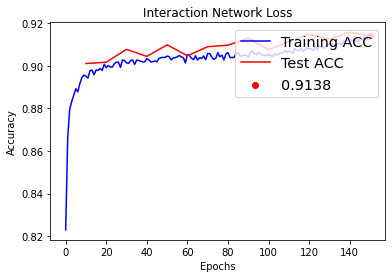

In [20]:
model = make_model(
    name = "GCN",
    inputs = [{'shape': (None, 13), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
            {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
    input_embedding = {"node": {"input_dim": 55, "output_dim": 64},
                       "edge": {"input_dim": 10, "output_dim": 64}},
    output_embedding =  'graph',
    output_mlp = {"use_bias": [True, True, False], "units": [140, 70, 1],
                "activation": ['relu', 'relu', 'sigmoid']},
    gcn_args = {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean', 
                "normalize_by_weights": False},
    depth = 1
)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.show()

In [21]:
probability = model.predict(xtest)
predictions = np.round(probability)
comparison = np.concatenate((predictions, ytest, probability), axis=1)
# print(comparison)

hole = 0
true = 0
false = 0
hole2 = 0
true2 = 0
false2 = 0
for value in comparison:
    if value[1] == 1.:
        hole += 1
        if value[0] == 0.:
            false +=1
        else:
            true +=1
    if value[1] == 0.:
        hole2 += 1
        if value[0] == 1.:
            false2 +=1
        else:
            true2 +=1
print(f"{true}/{hole}")
print(f"{false}/{hole}")
print(f"{true2}/{hole2}")
print(f"{false2}/{hole2}")

1243/1531
288/1531
4796/5078
282/5078


In [ ]:
A[A!=0] = 1
R[R!=0] = 1
intersection = A*R
union = A + R
union[union!=0] = 1
Jackard = np.sum(intersection)/np.sum(union)
print(Jackard)

In [22]:
predicted_images = {}

for (i, subgraph) in enumerate(subgraphs_test):
    if subgraph.rag.file_id not in predicted_images:
        predicted_images[subgraph.rag.file_id] = np.copy(subgraph.rag.superpixels_labels)
    predicted_images[subgraph.rag.file_id][ predicted_images[subgraph.rag.file_id] == subgraph.superpixel_label] = predictions[i] - 2

for key in predicted_images.keys():
    predicted_images[key][predicted_images[key] == -1] = 1
    predicted_images[key][predicted_images[key] == -2] = 0
    predicted_images[key]=predicted_images[key]*255
    im = Image.fromarray(predicted_images[key].astype(np.uint8))
    im.save(f"predictions/{key}.png")

In [ ]:
save_object('saved_objects/rags', rags)
save_object('saved_objects/neighbor_graphs', neighbor_graphs)
save_object('saved_objects/labels', labels)
save_object('saved_objects/nodes', nodes)
save_object('saved_objects/edges', edges)
save_object('saved_objects/edge_indices', edge_indices)
model.save('/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/saved_objects')

In [4]:
rags = load_object('saved_objects/rags')
neighbor_graphs = load_object('saved_objects/neighbor_graphs')
nodes = load_object('saved_objects/nodes')
edges = load_object('saved_objects/edges')
edge_indices = load_object('saved_objects/edge_indices')
labels = load_object('saved_objects/labels')
model = keras.models.load_model('/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/saved_objects')